<a href="https://colab.research.google.com/github/hye0-n0/hye0-n0/blob/main/hye0-n0/MLDL/%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 텐서플로 버전, 사용가능한 GPU
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
print('GPU 여부:', len(tf.config.list_physical_devices('GPU')) > 0)

GPU 여부: True


In [ ]:
if tf.config.list_physical_devices('GPU'):
  device_name = tf.test.gpu_device_name()
else:
  device_name = '/CPU:0'
print(device_name)

/device:GPU:0


## 생성자, 판별자 신경망 구현
### 바닐라 GAN
LeakyReLU : 입력 값 전 범위에 걸쳐 그레이디언트가 필요
![image](https://camo.githubusercontent.com/e69e2cf20481b01ca68b8636020885c93d17b177892ff9c46a77abd46513f051/68747470733a2f2f6769742e696f2f4a4c415168)
-----
![image](https://github.com/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch17/images/17_08.png?raw=true)

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

### 생성자 함수 정의 

In [ ]:
def make_generator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=784):
  
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(units=num_hidden_units, use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Dense(units=num_output_units, activation='tanh'))

    return model 

### 판별자 함수 정의

In [ ]:
def make_discriminator_network(
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(units=num_hidden_units))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Dense(units=num_output_units, activation=None))

    return model

### 모델 훈련을 위한 설정

In [ ]:
image_size=(28, 28)
z_size = 20
mode_z = 'uniform'    #'uniform' vs 'normal'

gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

In [ ]:
tf.random.set_seed(1)

In [ ]:
gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

gen_model.build(input_shape=(None, z_size))     # (행, 열, 채널 수)

gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               79184     
                                                                 
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [ ]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

disc_model.build(input_shape=(None, np.prod(image_size)))

disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


### 훈련 데이터셋 정의
합성된 이미지의 픽셀 값 범위 : (-1, 1)   
입력 이미지 픽셀 값 범위 : (0, 255) => tf.unit8

#### tf.image.convert_image_dtype 함수를 이용
1. 입력 이미지 텐서의 dtype :  tf.unit8 -> tf.float32

2. 픽셀 강도의 범위 : (0, 1)로 바꿈

벡터 z : 생성자가 새로운 이미지를 위해 받는 입력
이미지 : 판별자의 입력

In [ ]:
mnist_bdlr = tfds.builder('mnist')
mnist_bdlr.download_and_prepare()
mnist = mnist_bdlr.as_dataset(shuffle_files=False)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [-1])   # 1차원의 벡터인 1-D 텐서
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

In [ ]:
mnist_trainset = mnist['train']

print('전처리 전:  ')
example = next(iter(mnist_trainset))['image']
print('dtype: ', example.dtype, ' 최소: {} 최대: {}'.format(np.min(example), np.max(example)))

mnist_trainset = mnist_trainset.map(preprocess)

print('전처리 후:  ')
example = next(iter(mnist_trainset))[0]
print('dtype: ', example.dtype, ' 최소: {} 최대: {}'.format(np.min(example), np.max(example)))

전처리 전:  
dtype:  <dtype: 'uint8'>  최소: 0 최대: 255
전처리 후:  
dtype:  <dtype: 'float32'>  최소: -0.8737728595733643 최대: 0.9460210800170898


In [ ]:
# 배치 생성 후 이터레이터 next 호출
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))

print('input-z -- 크기:', input_z.shape)
print('input-real -- 크기:', input_real.shape)

input-z -- 크기: (32, 20)
input-real -- 크기: (32, 784)


In [ ]:
g_output = gen_model(input_z)
print('생성자 출력 -- 크기:', g_output.shape)

생성자 출력 -- 크기: (32, 784)


In [ ]:
d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)

print('판별자 (진짜) -- 크기:', d_logits_real.shape)
print('판별자 (가짜) -- 크기:', d_logits_fake.shape)

판별자 (진짜) -- 크기: (32, 1)
판별자 (가짜) -- 크기: (32, 1)


## GAN 모델 훈련
생성자와 판별자 손실 계산을 위해 출력에 대한 정답 레이블 필요
* 생성자 : 1로 채워진 벡터(생성된 이미지인 d_logits_fake 크기 동일)
* 판별자 : 가짜 샘플 감지, 진짜 샘플 감지하는 두 개의 손실

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# 생성자 손실
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('생성자 손실: {:.4f}'.format(g_loss))

생성자 손실: 0.7355


In [ ]:
# 판별자 손실
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true=d_labels_real,
                      y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake,
                      y_pred=d_logits_fake)
print('판별자 손실: 진짜 {:.4f} , 가짜 {:.4f}'.format(d_loss_real.numpy(), d_loss_fake.numpy()))

판별자 손실: 진짜 1.5073 , 가짜 0.6583


### GAN 모델 생성 후 가중치 최적화

In [ ]:
import time

In [ ]:
num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'

gen_hidden_layers = 1
gen_hidden_size  = 100
disc_hidden_layers = 1
disc_hidden_size  = 100

In [ ]:
tf.random.set_seed(1)
np.random.seed(1)

In [ ]:
if mode_z == 'uniform':
  fixed_z = tf.random.uniform(shape=(batch_size, z_size), minval=-1, maxval=1)
elif mode_z == 'normal':
  fixed_z = tf.random.normal(shape=(batch_size, z_size))

In [ ]:
def create_samples(g_model, input_z):
  g_output = g_model(input_z, training=False)
  images = tf.reshape(g_output, (batch_size, *image_size))
  return (images + 1)/2

In [ ]:
# 데이터셋 준비
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))
mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(batch_size, drop_remainder=True)

In [ ]:
# 모델 준비
with tf.device(device_name):    # GPU 사용
  gen_model = make_generator_network(
      num_hidden_layers=gen_hidden_layers,
      num_hidden_units=gen_hidden_size,
      num_output_units=np.prod(image_size))
  gen_model.build(input_shape=(None, z_size))

  disc_model = make_discriminator_network(
      num_hidden_layers=disc_hidden_layers,
      num_hidden_units=disc_hidden_size)
  disc_model.build(input_shape=(None, np.prod(image_size)))

In [ ]:
# 손실함수, 옵티마이저
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []
start_time = time.time()

for epoch in range(1, num_epochs+1):

  epoch_losses, epoch_d_vals = [], []

  for i, (input_z, input_real) in enumerate(mnist_trainset):

    # 생성자 손실 계산
    with tf.GradientTape() as g_tape:
      g_output = gen_model(input_z)
      d_logits_fake = disc_model(g_output, training=True)
      labels_real = tf.ones_like(d_logits_fake)
      g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
    
    # g_loss의 그레이디언트 계산
    g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)

    # 최적화: 그레이디언트 적용
    g_optimizer.apply_gradients(grads_and_vars=zip(g_grads, gen_model.trainable_variables))


    # 판별자 손실 계산
    with tf.GradientTape() as d_tape:
      d_logits_real = disc_model(input_real, training=True)

      d_labels_real = tf.ones_like(d_logits_real)

      d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)

      d_logits_fake = disc_model(g_output, training=True)

      d_labels_fake = tf.zeros_like(d_logits_fake)

      d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)

      d_loss = d_loss_real + d_loss_fake

    # d_loss의 그레이디언트 계산
    d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)

    # 최적화: 그레이디언트 적용
    d_optimizer.apply_gradients(grads_and_vars=zip(d_grads, disc_model.trainable_variables))

    epoch_losses.append((g_loss.numpy(), d_loss.numpy(), d_loss_real.numpy(), d_loss_fake.numpy()))

    d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))

    d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))

    epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))


  all_losses.append(epoch_losses)
  all_d_vals.append(epoch_d_vals)
  print(
      '에포크 {:03d} | 시간 {:2f} min | 평균 손실 >>'
      '생성자/판별자 {:.4f}/{:.4f} [판별자-진짜: {:.4f}  판별자-가짜: {:.4f}'
      .format(epoch, (time.time() - start_time/60), 
              *list(np.mean(all_losses[-1], axis=0))))
  epoch_samples.append(create_samples(gen_model, fixed_z).numpy())

에포크 001 | 시간 1647760124.259574 min | 평균 손실 >>생성자/판별자 2.8636/0.2891 [판별자-진짜: 0.0333  판별자-가짜: 0.2557
에포크 002 | 시간 1647760150.766251 min | 평균 손실 >>생성자/판별자 5.2835/0.3506 [판별자-진짜: 0.1138  판별자-가짜: 0.2368
에포크 003 | 시간 1647760178.080704 min | 평균 손실 >>생성자/판별자 3.2450/0.6817 [판별자-진짜: 0.3059  판별자-가짜: 0.3759
에포크 004 | 시간 1647760204.416248 min | 평균 손실 >>생성자/판별자 2.1822/0.8143 [판별자-진짜: 0.4273  판별자-가짜: 0.3869
에포크 005 | 시간 1647760245.362148 min | 평균 손실 >>생성자/판별자 2.1797/0.8112 [판별자-진짜: 0.4368  판별자-가짜: 0.3743
에포크 006 | 시간 1647760276.389664 min | 평균 손실 >>생성자/판별자 1.8297/0.8763 [판별자-진짜: 0.4842  판별자-가짜: 0.3921
에포크 007 | 시간 1647760317.922786 min | 평균 손실 >>생성자/판별자 1.6595/0.9589 [판별자-진짜: 0.5147  판별자-가짜: 0.4442
에포크 008 | 시간 1647760344.221721 min | 평균 손실 >>생성자/판별자 1.5205/0.9992 [판별자-진짜: 0.5434  판별자-가짜: 0.4558
에포크 009 | 시간 1647760370.247277 min | 평균 손실 >>생성자/판별자 1.2897/1.0972 [판별자-진짜: 0.5859  판별자-가짜: 0.5112
에포크 010 | 시간 1647760397.077502 min | 평균 손실 >>생성자/판별자 1.4369/1.0186 [판별자-진짜: 0.5523  판별자-가짜: 0.4663
에포크 011 | 

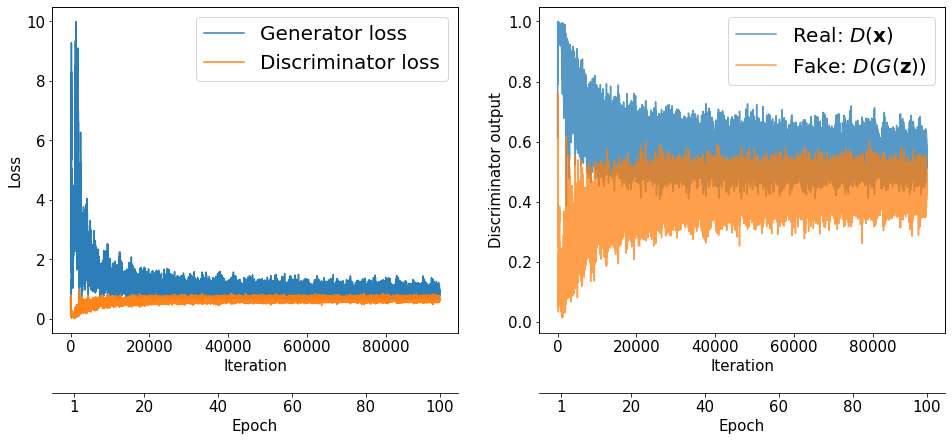

In [ ]:
import itertools
fig = plt.figure(figsize=(16, 6))
# 손실 그래프
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2 for item in itertools.chain(*all_losses)]

plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)

ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

# 판별자 출력
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]

plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)

ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)


plt.show()

훈련이 진행되면서 생성자가 더 진짜같은 이미지를 합성   
진짜와 가짜 샘플에 대한 확률이 모두 0.5에 가까워짐

#### 훈련동안 합성된 이미지의 변화

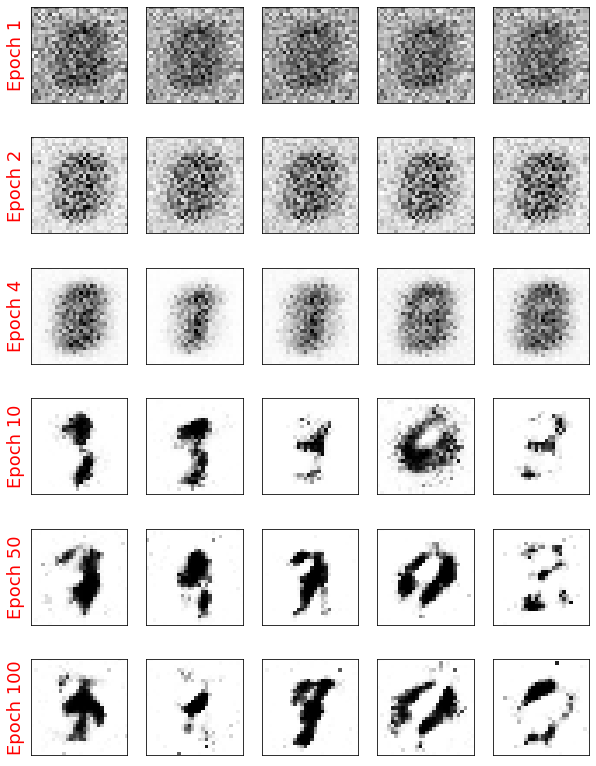

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()